https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning#Analysis 

In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -q fastkaggle

# from fastkaggle import *
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
from os.path import dirname, abspath
current_dir = os.getcwd()
root_dir = dirname(current_dir)
sys.path.append(os.path.join(root_dir, "src"))
print(root_dir)

/home/ash/ak/code/paddy


In [4]:
# Fastai and core
from fastai.metrics import error_rate
from fastai.callback.schedule import valley, slide


In [5]:
## Vision
import timm
from fastai.data.transforms import get_image_files
from fastai.vision.core import PILImage
from fastai.vision.data import ImageDataLoaders
from fastai.vision.augment import Resize, aug_transforms
from fastai.vision.learner import vision_learner


In [6]:
from configs import competition, data_path
from competition_utils import setup_competition

In [7]:
path = setup_competition(competition, data_path, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')
path

100%|██████████| 1.02G/1.02G [00:45<00:00, 23.8MB/s]


Path('/home/ash/ak/data/paddy-disease-classification')

In [8]:
path.ls()

(#5) [Path('/home/ash/ak/data/paddy-disease-classification/test_images'),Path('/home/ash/ak/data/paddy-disease-classification/train.csv'),Path('/home/ash/ak/data/paddy-disease-classification/sample_submission.csv'),Path('/home/ash/ak/data/paddy-disease-classification/train_images'),Path('/home/ash/ak/data/paddy-disease-classification/paddy-disease-classification.zip')]

In [9]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

In [ ]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

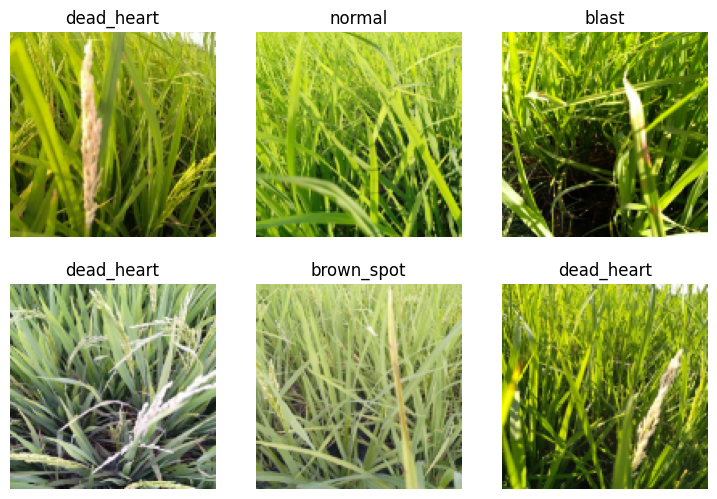

In [12]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

In [13]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /home/ash/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


SuggestedLRs(valley=0.002511886414140463, slide=0.007585775572806597)

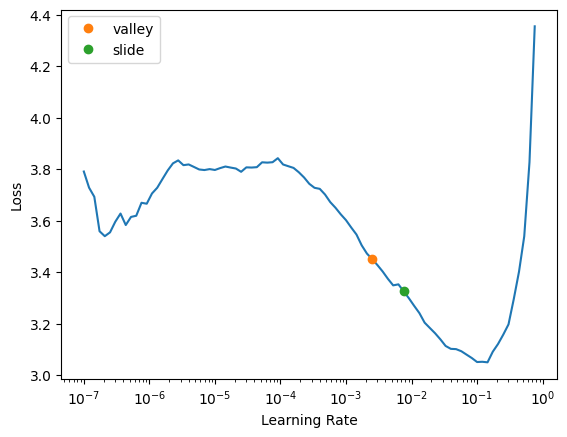

In [14]:
learn.lr_find(suggest_funcs=(valley, slide))


In [15]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.772515,1.258538,0.403172,00:28


epoch,train_loss,valid_loss,error_rate,time
0,1.110111,0.807760,0.260932,00:35
1,0.791016,0.462089,0.142720,00:34
2,0.528610,0.391115,0.123498,00:34


In [18]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [16]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

In [17]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

TensorBase([7, 8, 4,  ..., 8, 1, 5])

In [19]:
dls.vocab


['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [20]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                       hispa
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [21]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,hispa
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [1]:
from fastkaggle.core import iskaggle, push_notebook

In [22]:

if not iskaggle:
    from kaggle import api
    api.competition_submit_cli(
        'subm.csv', 
        'initial rn26d 128px', 
        competition
    )
    push_notebook(
        'khatkeashish', 
        'paddy',
        title='Paddy',
        file='comp_sub.ipynb',
        competition=competition, 
        private=False, 
        gpu=True
    )

100%|██████████| 69.9k/69.9k [00:01<00:00, 37.2kB/s]
